In [1]:
import sys
sys.path.insert(0, '/home/kolai/Projects/nfblab/nfb/')

import numpy as np
import pandas as pd
import pickle
import pylab as plt
import seaborn as sns

from collections import namedtuple
from pynfb.signal_processing.decompositions import ICADecomposition, CSPDecomposition
from pynfb.postprocessing.utils import load_data, runica2, band_hilbert
from pynfb.signal_processing.helpers import get_outliers_mask
from pynfb.inlets.montage import Montage
from mne.viz import plot_topomap
from scipy import signal
from statsmodels.stats.anova import AnovaRM
from scipy.stats import shapiro, levene

In [2]:
wdir = '/home/kolai/Projects/vibro_smr/'
data_dir = '/home/kolai/Data/vibro_smr/'

In [3]:
exps = pd.read_csv(wdir + 'info/vibro-decay-2.csv')
exps = exps.loc[exps.notes!='bad']

exclude_subjs =  ['ha-is', 'va-ba']
exps = exps.loc[~exps.name.isin(exclude_subjs)]

protocols = ['belt', 'belt-control']
exps = exps.loc[exps.protocol.isin(protocols)]

subjects = sorted(exps.name.unique())[:]

def get_dataset(subj, day, cond):
    subj_mask = exps.name==subj
    day_mask = exps.protocol=={1: 'belt', 2: 'belt-control'}[day]
    cond_mask = exps.control==(0 if cond==2 else 1)
    dataset = exps.loc[ subj_mask & day_mask & cond_mask , 'dataset'].values[0]
    print(dataset)
    df, fs, p_names, channels = load_data('{}{}/experiment_data.h5'.format(data_dir, dataset))
    if fs == 1000:
        df = df.iloc[::2]
        fs = 500
    montage = Montage(channels)
    channels = montage.get_names('EEG')
    
    ch_to_fix = {'C5': 'Ft9', 'C6': 'Ft10'}
    if subj+str(day) in ['ks-vo1', 'kr-vo1']:
        channels = [(ch_to_fix[ch] if ch in ch_to_fix else ch) for ch in channels]
        df.columns = [(ch_to_fix[ch] if ch in ch_to_fix else ch) for ch in df.columns]
        
    
    columns = channels + ['block_name', 'block_number']
        
    return df[columns], fs, p_names, channels

exps

,subject,name,dataset,protocol,control,bias,notes
1,s0,va-bu,vibro-decay_12-09_12-36-50,belt,1,1.0,NaN
2,s0,va-bu,vibro-decay-1min_12-09_13-32-49,belt,0,1.0,NaN
3,s2,ks-vo,vibro-decay-s2-control_12-28_14-06-53,belt,1,1.0,NaN
4,s2,ks-vo,vibro-decay-s2-real_12-28_14-23-54,belt,0,1.0,vibro-ring
5,s3,ni-sm,vibro-decay-s3_contol_12-28_16-35-39,belt,1,1.0,NaN
6,s3,ni-sm,vibro-decay-s3-real_12-28_16-53-18,belt,0,1.0,NaN
7,s1,kr-vo,vibro-decay-s1-v2-exp_12-27_15-02-39,belt,0,0.0,NaN
8,s1,kr-vo,vibro-decay-s1-v2-control_12-27_15-22-39,belt,1,0.0,NaN
13,rs,ro-so,vibro-decay-rs-beltcontrol_01-19_13-15-01,belt,1,1.0,NaN
14,rs,ro-so,vibro-decay-rs-beltexp_01-19_13-40-10,belt,0,1.0,NaN


In [4]:
def erd_scores(ica, ica_data, names, fs):    
    erds = []
    for j in range(len(ica.topographies)):
        component = ica_data.dot(ica.filters[:, j])
        f, t, Sxx = signal.spectrogram(component[names=='Motor'], fs, scaling='spectrum', nperseg=fs*10, nfft=fs*10, noverlap=10*int(fs*0.8))
        motor = np.median(Sxx[(f>7)&(f<30)].mean(0))
        f, t, Sxx = signal.spectrogram(component[names=='Rest'], fs, scaling='spectrum', nperseg=fs*10, nfft=fs*10, noverlap=10*int(fs*0.8))
        rest = np.median(Sxx[(f>7)&(f<30)].mean(0))
        erds.append((rest-motor)/rest*100)
    return erds

def get_ica_data(subj, day):
        df, fs, p_names, channels = get_dataset(subj, day, cond=1)
        ica_data = df.loc[df.block_number.isin([1, 2, 8, 9])]
        df, fs, p_names, channels = get_dataset(subj, day, cond=2)
        ica_data = pd.concat([ica_data, df.loc[df.block_number.isin([1, 2, 8, 9])]], ignore_index=True)
        names = ica_data.block_name.values
        ica_data = ica_data[channels].values
        return ica_data, names, fs, channels
    
def plot_first_n_topo(n_comps, ica, erds, channels):
        fig, axes = plt.subplots(1, n_comps, figsize=(10,3))
        for k in range(n_comps):
            ind = np.argsort(erds)[::-1][k]
            topo = ica.topographies[:, ind]
            pos = Montage(channels).get_pos()
            plot_topomap(topo, pos, axes=axes[k], show=False, contours=0)
            hem = 'i' if pos[np.argmax(np.abs(topo))][0]>0 else 'c'
            axes[k].set_xlabel('hem = {}\nerd = {:d}%'.format(hem, int(erds[ind])))
            axes[k].set_title(str(k+1))
        plt.suptitle('{} d{}'.format(subj, day))

def cast_channels(channels, topo):
    modif_ch_neib = {
        'Cpz': ['Cz', 'Pz', 'Cp1', 'Cp2'],
        'Fcz': ['Cz', 'Fz', 'Fc1', 'Fc2'],
        'C1': ['Cz', 'C3', 'Cp1', 'Fc1'],
        'C2': ['Cz', 'C4', 'Cp2', 'Fc2']
    }
    modif_ch = {
        'F7': 'Cpz',
        'C5': 'C1',
        'F8': 'Fcz',
        'C6': 'C2',
        'Ft10': 'C2',
        'Ft9': 'C1',
    }
    for ch, ch_new in modif_ch.items():

        if ch in channels:
            topo[channels.index(ch)] = np.mean([topo[j] for j in range(len(channels)) if channels[j] in modif_ch_neib[ch_new]])
            channels[channels.index(ch)]=ch_new
    return channels, topo

def get_spec(x):
    n_smooth = 10
    f, t, Sxx = signal.spectrogram(x, fs, scaling='spectrum', nperseg=fs*10, nfft=fs*10, noverlap=10*int(fs*0.8))
    Sxx = Sxx**0.5 * 1e6
    s = signal.filtfilt(np.arange(n_smooth)/n_smooth,[1],np.median(Sxx, 1))
    return f, s

def get_band(erd, f, band, mass=0.5):
    alpha_mask = (f>band[0]) & (f<band[1])
    ext_mask = alpha_mask & (erd > 0)
    all_sum = np.sum(f[ext_mask]*erd[ext_mask])
    f_low = f[ext_mask][np.argmin(np.abs((np.cumsum(f[ext_mask]*erd[ext_mask]) - all_sum*(1/2-mass/2))))]
    f_high = f[ext_mask][np.argmin(np.abs((np.cumsum(f[ext_mask]*erd[ext_mask]) - all_sum*(1/2+mass/2))))]
    return f_low, f_high, ext_mask

def get_bands(rest, motor):
    f, s_rest = get_spec(rest)
    f, s_motor = get_spec(motor)        
    mass=0.50
    erd=(s_rest-s_motor)/s_rest
    bands = []
    f_low, f_high, ext_mask = get_band(erd, f, [7, 15], mass)
    bands.append(('alpha', [f_low, f_high]))
    f_low, f_high, ext_mask = get_band(erd, f, [15, 30], mass)
    bands.append(('beta', [f_low, f_high]))
    return bands

In [5]:
SMRMeta = namedtuple('SMRMeta', ['c_topo', 'i_topo', 'c_filt', 'i_filt', 'montage', 'c_erd', 'i_erd', 'c_bands', 'i_bands'])
load_smr_meta = True
recompute_ica = False

if load_smr_meta:
    with open('../filters/smr_meta.pkl', 'rb') as handle:
        smr_meta = pickle.load(handle)
        
    print('smr meta was loaded')
else:
    comp_info = pd.read_csv(wdir + 'info/vibro-components.csv')

    smr_meta = {}
    # comp_info

    for subj in sorted(exps.name.unique())[:]:
        for day in [1,2]:
            ica_data, names, fs, channels = get_ica_data(subj, day)

            if recompute_ica:
                ica = ICADecomposition(channels, fs, (7, 30))
                ica = CSPDecomposition(channels, fs, (7, 30))
                ica.fit(ica_data, names=='Rest')
            else:
                with open('../filters/ica_pkl_band2/{}_d{}.pkl'.format(subj, day), 'rb') as handle:
                    ica = pickle.load(handle)

            erds = erd_scores(ica, ica_data, names, fs)

            plot_first_n_topo(5, ica, erds, channels)

            if recompute_ica:    
                plt.savefig('../imag/csp_topos_erd_sorted_band2/{}_d{}.png'.format(subj, day), dpi=200)
                with open('../filters/csp_pkl_band2/{}_d{}.pkl'.format(subj, day), 'wb') as handle:
                    pickle.dump(ica, handle)

            plt.show()


            c, i = comp_info.loc[(comp_info.subj==subj)&(comp_info.day==day), ['c', 'i']].values[0]-1
            montage = Montage(channels)
            ind = np.argsort(erds)[::-1]

            x = ica_data.dot(ica.filters[:, ind[c]])
            c_bands = get_bands(x[names=='Rest'], x[names=='Motor'])
            x = ica_data.dot(ica.filters[:, ind[i]])
            i_bands = get_bands(x[names=='Rest'], x[names=='Motor'])
            
            smr_meta[subj+str(day)] = SMRMeta(
                c_topo=ica.topographies[:, ind[c]],
                i_topo=ica.topographies[:, ind[i]],
                c_filt=ica.filters[:, ind[c]],
                i_filt=ica.filters[:, ind[i]],
                c_erd=erds[ind[c]],
                i_erd=erds[ind[i]],
                c_bands=c_bands,
                i_bands=i_bands,
                montage=montage)
            



    with open('../filters/smr_meta.pkl', 'wb') as handle:
        pickle.dump(smr_meta, handle)
        
    


smr meta was loaded


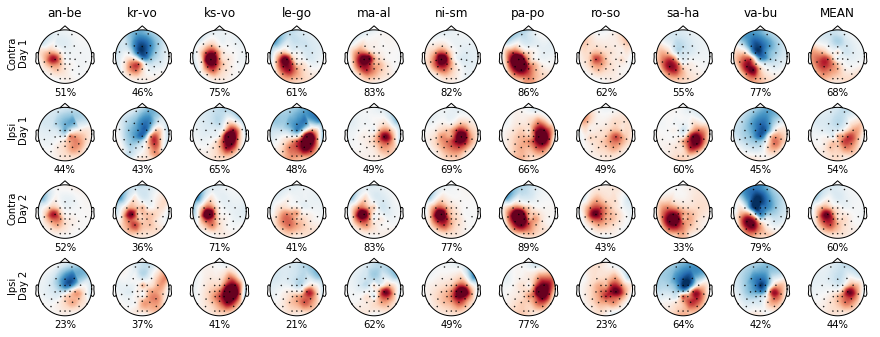

In [6]:
fig, axes = plt.subplots(4, len(subjects)+1, figsize=(15,5))
c_topos = np.zeros((10, 2, 32))
i_topos = np.zeros((10, 2, 32))
c_erds = np.zeros((10, 2))
i_erds = np.zeros((10, 2))

vmin=-0.5
vmax=0.5
for day in [1,2]:
    for subj_j, subj in enumerate(subjects):
        s = smr_meta[subj+str(day)]
        i_topo = s.i_topo/np.sign(s.i_topo[s.montage.get_names().index('C4')])#/(s.i_topo.dot(s.i_topo))**0.5
        i_topo -= 1.01*np.min(np.abs(i_topo))
        c_topo = s.c_topo/np.sign(s.c_topo[s.montage.get_names().index('C3')])#/(s.c_topo.dot(s.c_topo))**0.5
        c_topo -= 1.01*np.min(np.abs(c_topo))
        plot_topomap(i_topo, s.montage.get_pos(), axes=axes[(day-1)*2+1, subj_j], show=False, contours=0, vmin=vmin, vmax=vmax)
        plot_topomap(c_topo, s.montage.get_pos(), axes=axes[(day-1)*2, subj_j], show=False, contours=0, vmin=vmin, vmax=vmax)
        channels, c_topos[subj_j, day-1] = cast_channels(s.montage.get_names(), c_topo)
        channels, i_topos[subj_j, day-1] = cast_channels(s.montage.get_names(), i_topo)
        c_erds[subj_j, day-1] = s.c_erd
        i_erds[subj_j, day-1] = s.i_erd
        axes[0, subj_j].set_title(subj)
        axes[(day-1)*2+1, subj_j].set_xlabel('{}%'.format(int(s.i_erd)))
        axes[(day-1)*2, subj_j].set_xlabel('{}%'.format(int(s.c_erd)))
    
    axes[0, -1].set_title('MEAN')
    plot_topomap(c_topos.mean(0)[day-1], Montage(channels).get_pos(), axes=axes[(day-1)*2, 10], show=False, contours=0, vmin=vmin, vmax=vmax)
    plot_topomap(i_topos.mean(0)[day-1], Montage(channels).get_pos(), axes=axes[(day-1)*2+1, 10], show=False, contours=0, vmin=vmin, vmax=vmax)

    axes[(day-1)*2+1, -1].set_xlabel('{}%'.format(int(i_erds.mean(0)[day-1])))
    axes[(day-1)*2, -1].set_xlabel('{}%'.format(int(c_erds.mean(0)[day-1])))
axes[0, 0].set_ylabel('Contra\nDay 1')
axes[1, 0].set_ylabel('Ipsi\nDay 1')
axes[2, 0].set_ylabel('Contra\nDay 2')
axes[3, 0].set_ylabel('Ipsi\nDay 2')
        
plt.savefig('../imag/ica_all_components.png', dpi=200)

In [7]:

stats = pd.DataFrame(columns=['subj', 'stim_number', 'band', 'hemisphere', 'condition', 'day', 'magnitude'])
for subj in subjects:
    for day in [1,2]:
        s = smr_meta[subj+str(day)]
        for cond in [1, 2]:
            df, fs, p_names, channels = get_dataset(subj, day, cond)
            df['c'] = df[channels].dot(s.c_filt)
            df['i'] = df[channels].dot(s.i_filt)
    
            for hem in ['c', 'i']:
                bands = s.c_bands if hem=='c' else s.i_bands
                #bands = [('alpha', [8, 15]), ('beta', [20, 28])]
                print(bands)
                for b_number in df.block_number.unique():
                    if b_number in [4,6]:
                        continue
                    
                    x = df.loc[df.block_number == b_number, hem].values
                    f, t, Sxx = signal.spectrogram(x, fs, scaling='spectrum', nperseg=fs*10, nfft=fs*10, noverlap=10*int(fs*0.8))
                    Sxx = Sxx**0.5 * 1e6
                    row_dict = list({'subj': subj, 
                                'stim_number': b_number, 
                                'hemisphere': hem, 
                                'condition': cond,
                                'day': day}.items())
                    for band_name, band in bands:
                        magnitude = np.median(np.mean(Sxx[(f>=band[0]) & (f<=band[1])], 0))
                        stats.loc[len(stats)] = dict(row_dict + [('band', band_name), ('magnitude', magnitude)])

vibro-decay-anbe-control_03-02_14-01-31
fs: 1000
all labels 38: ['Fp1', 'Fp2', 'Cpz', 'F3', 'Fz', 'F4', 'FCz', 'C1', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'Myo1', 'Myo2', 'Myo3', 'Myo4', 'Myo5', 'Myo6']
selected channels 38: ['Fp1', 'Fp2', 'Cpz', 'F3', 'Fz', 'F4', 'FCz', 'C1', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'Myo1', 'Myo2', 'Myo3', 'Myo4', 'Myo5', 'Myo6']
protocol_names: ['Rest', 'Motor', 'Rest', 'Pause', 'Vibration', 'Pause', 'Rest', 'Motor', 'Rest']
[('alpha', [11.0, 12.700000000000001]), ('beta', [20.600000000000001, 24.100000000000001])]
[('alpha', [10.9, 12.600000000000001]), ('beta', [21.5, 25.0])]
vibro-decay-anbe-exp_03-02_14-19-20
fs: 1000
all labels 38: ['Fp1', 'Fp2', 'Cpz', 'F3', 'Fz', 'F4', 'FCz', 'C1', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', '

[('alpha', [10.100000000000001, 13.0]), ('beta', [20.100000000000001, 25.300000000000001])]
[('alpha', [9.0999999999999996, 11.800000000000001]), ('beta', [19.5, 23.800000000000001])]
exp2-block2-ksvo_05-29_17-00-40
fs: 500
all labels 32: ['Fp1', 'Fp2', 'CPz', 'F3', 'Fz', 'F4', 'C1', 'FCz', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'Pz', 'P8', 'O1', 'Oz', 'O2', 'T7']
selected channels 32: ['Fp1', 'Fp2', 'CPz', 'F3', 'Fz', 'F4', 'C1', 'FCz', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'Pz', 'P8', 'O1', 'Oz', 'O2', 'T7']
protocol_names: ['Rest', 'Motor', 'Rest', 'Pause', 'Vibration', 'Pause', 'Rest', 'Motor', 'Rest']
[('alpha', [10.100000000000001, 13.0]), ('beta', [20.100000000000001, 25.300000000000001])]
[('alpha', [9.0999999999999996, 11.800000000000001]), ('beta', [19.5, 23.800000000000001])]
vibro-decay-lg-control_01-31_14-14-19
fs:

[('alpha', [9.9000000000000004, 13.200000000000001]), ('beta', [18.900000000000002, 25.700000000000003])]
[('alpha', [9.9000000000000004, 13.100000000000001]), ('beta', [18.600000000000001, 24.900000000000002])]
exp2block1_nism_04-22_18-42-56
fs: 500
all labels 32: ['Fp1', 'Fp2', 'CPz', 'F3', 'Fz', 'F4', 'C1', 'FCz', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'Pz', 'P8', 'O1', 'Oz', 'O2', 'T7']
selected channels 32: ['Fp1', 'Fp2', 'CPz', 'F3', 'Fz', 'F4', 'C1', 'FCz', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'Pz', 'P8', 'O1', 'Oz', 'O2', 'T7']
protocol_names: ['Rest', 'Motor', 'Rest', 'Pause', 'Vibration', 'Pause', 'Rest', 'Motor', 'Rest']
[('alpha', [10.4, 13.600000000000001]), ('beta', [18.5, 26.100000000000001])]
[('alpha', [10.700000000000001, 13.600000000000001]), ('beta', [19.0, 26.0])]
exp2block2_nism_04-22_19-17-15
fs: 500
all

[('alpha', [10.200000000000001, 12.100000000000001]), ('beta', [20.5, 23.700000000000003])]
[('alpha', [9.9000000000000004, 11.800000000000001]), ('beta', [19.0, 22.700000000000003])]
vibro-decay-saha-exp_03-02_19-51-38
fs: 1000
all labels 38: ['Fp1', 'Fp2', 'Cpz', 'F3', 'Fz', 'F4', 'FCz', 'C1', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'Myo1', 'Myo2', 'Myo3', 'Myo4', 'Myo5', 'Myo6']
selected channels 38: ['Fp1', 'Fp2', 'Cpz', 'F3', 'Fz', 'F4', 'FCz', 'C1', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'C2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'Myo1', 'Myo2', 'Myo3', 'Myo4', 'Myo5', 'Myo6']
protocol_names: ['Rest', 'Motor', 'Rest', 'Pause', 'Vibration', 'Pause', 'Rest', 'Motor', 'Rest']
[('alpha', [10.200000000000001, 12.100000000000001]), ('beta', [20.5, 23.700000000000003])]
[('alpha', [9.9000000000000004, 

In [8]:
stats_n = stats.copy()
stats_n['day_condition'] = 'day'+stats_n['day'].astype(str)+':cond'+stats_n['condition'].astype(str)
stats_n.sort_values(by=['subj', 'day_condition', 'band'], inplace=True)
for subj in stats.subj.unique():
    for condition in stats.condition.unique():
        for hem in stats.hemisphere.unique():
            for day in stats.day.unique():
                for band in stats.band.unique():
                    bool_slice = ((stats.subj == subj) &
                                    (stats.band == band) &
                                    (stats.condition == condition) &
                                    (stats.hemisphere == hem) &
                                    (stats.day == day))
                    coeff = stats.loc[bool_slice & (stats.stim_number == 3), 'magnitude'].iloc[0]
                    erd = lambda x: (coeff - x) / coeff * 100
                    for stim in stats.stim_number.unique():
                        stats_n.loc[bool_slice & (stats.stim_number == stim), 'magnitude'] =\
                        erd(stats_n.loc[bool_slice & (stats.stim_number == stim), 'magnitude'])

alpha day1
(0.9525554180145264, 0.09286928176879883)
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            46.3749 1.0000 9.0000 0.0001
hemisphere           21.8133 1.0000 9.0000 0.0012
condition:hemisphere  2.7825 1.0000 9.0000 0.1296

alpha day2
(0.9408077597618103, 0.03681940585374832)
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition             0.5323 1.0000 9.0000 0.4842
hemisphere           25.9427 1.0000 9.0000 0.0007
condition:hemisphere  0.2344 1.0000 9.0000 0.6399

beta day1
(0.9724977612495422, 0.4302450716495514)
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            10.4962 1.0000 9.0000 0.0102
hemisphere           31.9225 1.0000 9.0000 0.0003
condition:hemisphere  0.0083 1.0000 9.0000 0.9292

beta d

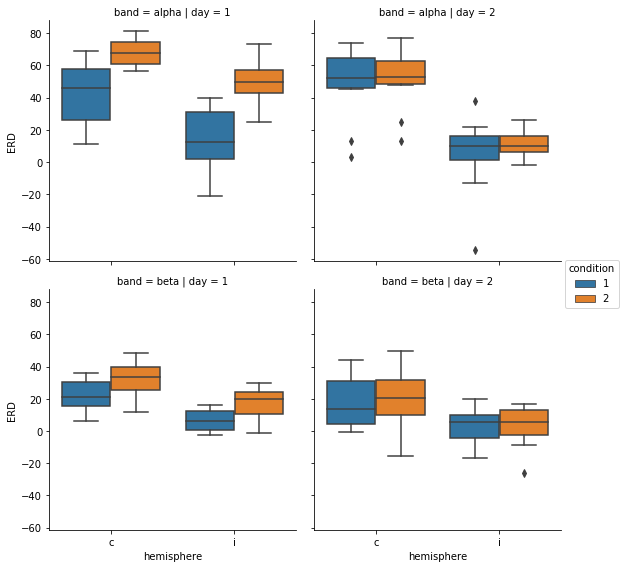

In [9]:
stim=5
stats_n['ERD']=stats_n['magnitude']
sns.factorplot('hemisphere', 'ERD', 'condition',stats_n.loc[(stats_n.stim_number==stim)],
               kind="box", col='day', row='band', dodge=0.1)
#plt.title('ERS(rest_before vs rest_after)' if stim==5 else 'ERD(rest_before vs intervention)')
#plt.ylim(-100, 100)

for band in ['alpha', 'beta']:
    for day in [1, 2]:
        erd = stats_n.loc[(stats_n.day==day) & (stats_n.band==band) & (stats_n.stim_number==5), 
                        ['subj', 'condition', 'hemisphere', 'ERD']]
        print('{} day{}'.format(band, day))
        print(shapiro(erd['ERD']))
        print(AnovaRM(erd, 'ERD', 'subj', ['condition', 'hemisphere']).fit().summary())

alpha day1
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition             5.7825 1.0000 9.0000 0.0396
hemisphere            2.7912 1.0000 9.0000 0.1291
condition:hemisphere  2.7839 1.0000 9.0000 0.1296

alpha day2
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition             3.7719 1.0000 9.0000 0.0840
hemisphere            0.6430 1.0000 9.0000 0.4433
condition:hemisphere  0.1106 1.0000 9.0000 0.7471

beta day1
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------------
condition            23.8535 1.0000 9.0000 0.0009
hemisphere            1.6631 1.0000 9.0000 0.2293
condition:hemisphere  3.1775 1.0000 9.0000 0.1083

beta day2
                      Anova
                     F Value Num DF Den DF Pr > F
-------------------------------------------

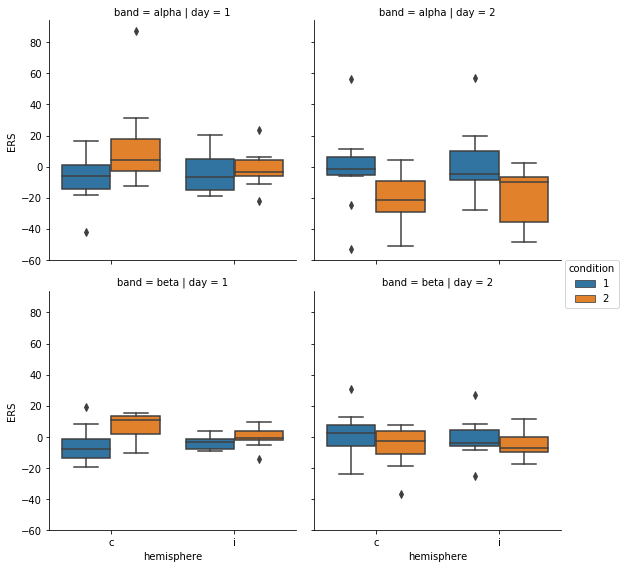

In [10]:
stim=7
stats_n['ERS']=-stats_n['magnitude']
sns.factorplot('hemisphere', 'ERS', 'condition', stats_n.loc[(stats_n.stim_number==stim)],
               kind="box", col='day', row='band', dodge=0.1)
#plt.title('ERS(rest_before vs rest_after)' if stim==5 else 'ERD(rest_before vs intervention)')
#plt.ylim(-50, 50)

for band in ['alpha', 'beta'][:]:
    for day in [1, 2]:
        erd = stats_n.loc[(stats_n.day==day) & (stats_n.band==band) & (stats_n.stim_number==stim), 
                        ['subj', 'condition', 'hemisphere', 'ERS']]
        print('{} day{}'.format(band, day))
        print(AnovaRM(erd, 'ERS', 'subj', ['condition', 'hemisphere']).fit().summary())

alpha condition1
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day             0.0393 1.0000 9.0000 0.8472
hemisphere     19.5665 1.0000 9.0000 0.0017
day:hemisphere  2.3441 1.0000 9.0000 0.1601

alpha condition2
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day            62.7755 1.0000 9.0000 0.0000
hemisphere     51.8736 1.0000 9.0000 0.0001
day:hemisphere 18.4160 1.0000 9.0000 0.0020

beta condition1
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day             0.2746 1.0000 9.0000 0.6129
hemisphere     18.0456 1.0000 9.0000 0.0021
day:hemisphere  0.0012 1.0000 9.0000 0.9733

beta condition2
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day            12.2613 1.0000 9.0000 0.0067
hemisphere     16.8511 1.0000 9.0000 0.

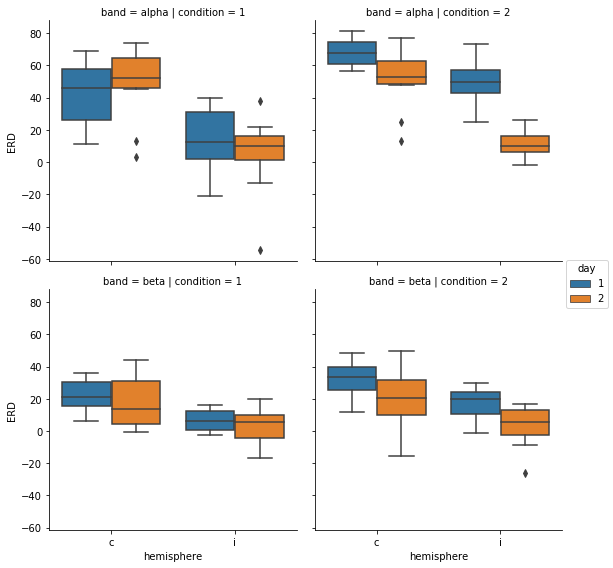

In [11]:
stim=5
stats_n['ERD']=stats_n['magnitude']
sns.factorplot('hemisphere', 'ERD', 'day', stats_n.loc[(stats_n.stim_number==stim)],
               kind="box", col='condition', row='band', dodge=0.1)
#plt.title('ERS(rest_before vs rest_after)' if stim==5 else 'ERD(rest_before vs intervention)')
#plt.ylim(-50, 50)

for band in ['alpha', 'beta'][:]:
    for condition in [1, 2]:
        erd = stats_n.loc[(stats_n.condition==condition) & (stats_n.band==band) & (stats_n.stim_number==stim), 
                        ['subj', 'day', 'hemisphere', 'ERD']]
        print('{} condition{}'.format(band, condition))
        print(AnovaRM(erd, 'ERD', 'subj', ['day', 'hemisphere']).fit().summary())

alpha condition1
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day             0.3327 1.0000 9.0000 0.5782
hemisphere      1.2838 1.0000 9.0000 0.2865
day:hemisphere  0.0061 1.0000 9.0000 0.9394

alpha condition2
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day            14.9404 1.0000 9.0000 0.0038
hemisphere      2.7430 1.0000 9.0000 0.1321
day:hemisphere  4.3658 1.0000 9.0000 0.0662

beta condition1
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day             0.8180 1.0000 9.0000 0.3893
hemisphere      0.0058 1.0000 9.0000 0.9410
day:hemisphere  1.2547 1.0000 9.0000 0.2917

beta condition2
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day             5.0147 1.0000 9.0000 0.0519
hemisphere      1.1843 1.0000 9.0000 0.

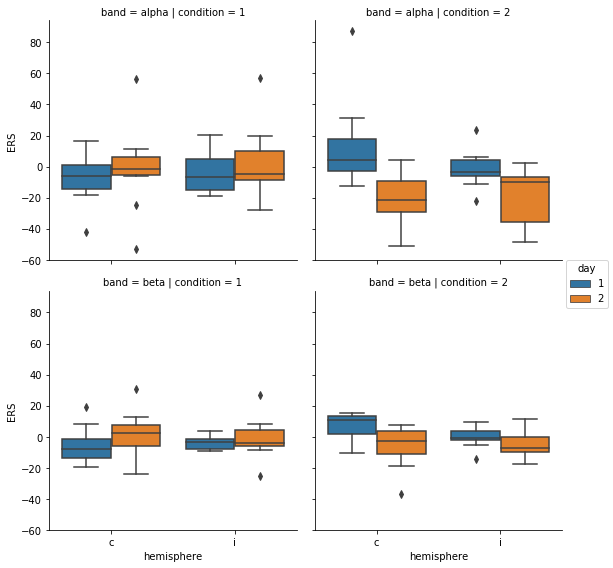

In [12]:
stim=7
stats_n['ERS']=-stats_n['magnitude']
sns.factorplot('hemisphere', 'ERS', 'day', stats_n.loc[(stats_n.stim_number==stim)],
               kind="box", col='condition', row='band', dodge=0.1)
#plt.title('ERS(rest_before vs rest_after)' if stim==5 else 'ERD(rest_before vs intervention)')
#plt.ylim(-50, 50)

for band in ['alpha', 'beta'][:]:
    for condition in [1, 2]:
        erd = stats_n.loc[(stats_n.condition==condition) & (stats_n.band==band) & (stats_n.stim_number==stim), 
                        ['subj', 'day', 'hemisphere', 'ERS']]
        print('{} condition{}'.format(band, condition))
        print(AnovaRM(erd, 'ERS', 'subj', ['day', 'hemisphere']).fit().summary())

In [27]:
for band in ['alpha'][:]:
    for day in [2]:
        erd = stats_n.loc[(stats_n.condition==day) & (stats_n.band==band) & (stats_n.stim_number==stim), 
                        ['subj', 'day', 'hemisphere', 'ERS']]
        print('{} day{}'.format(band, day))
        print(AnovaRM(erd, 'ERS', 'subj', ['day', 'hemisphere']).fit().summary())

alpha day2
                   Anova
               F Value Num DF Den DF Pr > F
-------------------------------------------
day            15.8390 1.0000 9.0000 0.0032
hemisphere      1.7535 1.0000 9.0000 0.2181
day:hemisphere  9.4128 1.0000 9.0000 0.0134



In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

erd['day_hem']=erd['day'].astype(str)+erd['hemisphere']
mc = MultiComparison(erd['ERS'], erd['day_hem'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1c     1i   -10.1073 -25.8582  5.6435 False 
  1c     2c   -23.0037 -38.7546 -7.2529  True 
  1c     2i   -20.1583 -35.9092 -4.4075  True 
  1i     2c   -12.8964 -28.6472  2.8545 False 
  1i     2i   -10.051  -25.8018  5.6998 False 
  2c     2i    2.8454  -12.9054 18.5962 False 
----------------------------------------------
['1c' '1i' '2c' '2i']
